# Partie 3 : Visualisation des données + K-means
## `20newsgroups` **sans** stopwords

In [ ]:

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.decomposition import PCA

import sys
sys.path.append('../') 

from iads import Clustering as clust

from iads.vectorization import get_bow_vect, get_tfidf_vect

from iads.preprocessing import get_corpus, clean_news, lemmatize_filter
from iads.clustering_eval import *

sns.set_theme()
plt.rcParams['font.family'] = 'Proxima Nova'

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Chargement des données et prétraitement

In [2]:
newsgroups_df = pd.read_csv("data/sample.csv")
stop_words_df = pd.read_csv("data/stopwords.csv")
stopwords = stop_words_df["stopword"].values.tolist()

news_no_stopwords = clean_news(newsgroups_df, stopwords, True, True)
news_no_stopwords = lemmatize_filter(news_no_stopwords, 3, 10)
corpus = get_corpus(news_no_stopwords)
news_no_stopwords

Number of Nans 48


,Message index,target,label,messages
0,0,0,alt.atheism,law seem value criminal life victim life islam...
1,1,0,alt.atheism,com bill newsgroups alt atheism organization s...
2,2,0,alt.atheism,true believer die belief jesus jim jones well ...
3,3,0,alt.atheism,knowing keith expect bring better oil well dry
4,4,0,alt.atheism,film medium alternative movie source may book ...
...,...,...,...,...
1810,1879,19,comp.os.ms-windows.misc,think mistaken thinking tom atheist find athei...
1811,1881,19,comp.os.ms-windows.misc,would religious belief therefore feel comforta...
1812,1882,19,comp.os.ms-windows.misc,extremely good example evidence every time rig...
1813,1883,19,comp.os.ms-windows.misc,vol part ocean translation turkish writing sai...


In [3]:
import colorcet as cc
def plot_3d_pca(M, U, random_state=None):
    model = PCA(3, random_state=random_state)
    proj = model.fit_transform(M)

    palette = sns.color_palette("tab20")

    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_subplot(111, projection='3d')
    plt.rcParams['font.family'] = 'Proxima Nova'
    data = pd.DataFrame(data={"x":proj[:, 0], "y":proj[:, 1], "z":proj[:, 2], "cluster":U})
    colors = [palette[t] for t in data["cluster"].values]

    ax.scatter(data["x"], data["y"], data["z"], c=colors, s=10, alpha=0.8)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")

    handles = [Patch(color=color, label=str(cluster)) for cluster, color in zip(np.unique(U), palette)]
    ax.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left', borderaxespad=0.0, title="Clusters")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.3, box.height * 0.3])

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # Transparent

    ax.set_title("PCA 3D", fontsize=15)
    plt.tight_layout()
    return fig

In [4]:
bow_bin_pca = 1132
bow_non_bin_pca = 1109
tfidf_pca = 1249

In [5]:
random.seed(1)
np.random.seed(1)
M = normalize(get_bow_vect(news_no_stopwords, corpus, binary=True))

# PCA dimensionality reduction
model = PCA(n_components=1132, random_state=1)
m_pca = model.fit_transform(M)

# KMeans
centroids, U = clust.kmoyennes(18, m_pca, 0, 300, verbose=False)
U = predict_label(U)

In [10]:
true_targets = news_no_stopwords["target"].values
assigned_clusters = U

actual_pd = pd.Categorical(true_targets, categories=np.unique(true_targets))

clusters, nb_points = np.unique(assigned_clusters, return_counts=True)
pred_pd = pd.Categorical(assigned_clusters, categories=clusters)

conf = pd.crosstab(actual_pd, pred_pd,
                       normalize=False,
                       colnames=["Clusters obtenus"],
                       rownames=["Nombre d'éléments d'un cluster d'origine"],
                       dropna=False)

pred_pd = pd.Categorical(assigned_clusters, categories=clusters)

pd.crosstab(actual_pd, pred_pd,
                       normalize=False,
                       colnames=["Clusters obtenus"],
                       rownames=["Nombre d'éléments d'un cluster d'origine"],
                       dropna=False)

Clusters obtenus,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Nombre d'éléments d'un cluster d'origine,,,,,,,,,,,,,,,,,,
0,1,0,4,0,2,3,9,2,1,3,5,28,1,13,0,6,0,0
1,1,1,4,15,3,1,4,1,19,6,3,3,8,3,15,1,4,2
2,3,0,2,30,5,1,2,2,20,4,2,0,8,7,6,1,3,0
3,4,0,3,4,4,0,2,4,25,6,4,0,6,8,16,5,2,1
4,2,1,7,2,6,0,4,6,11,13,4,0,2,6,16,6,4,1
5,3,0,0,24,4,1,2,1,18,10,7,1,1,9,10,0,2,5
6,25,0,2,0,1,0,1,26,6,3,2,0,3,11,4,1,12,1
7,9,0,5,1,1,2,3,1,8,9,5,3,1,19,3,12,4,6
8,6,0,8,1,7,1,5,1,4,6,4,7,1,26,0,15,5,0


### Bag-of-words binaire

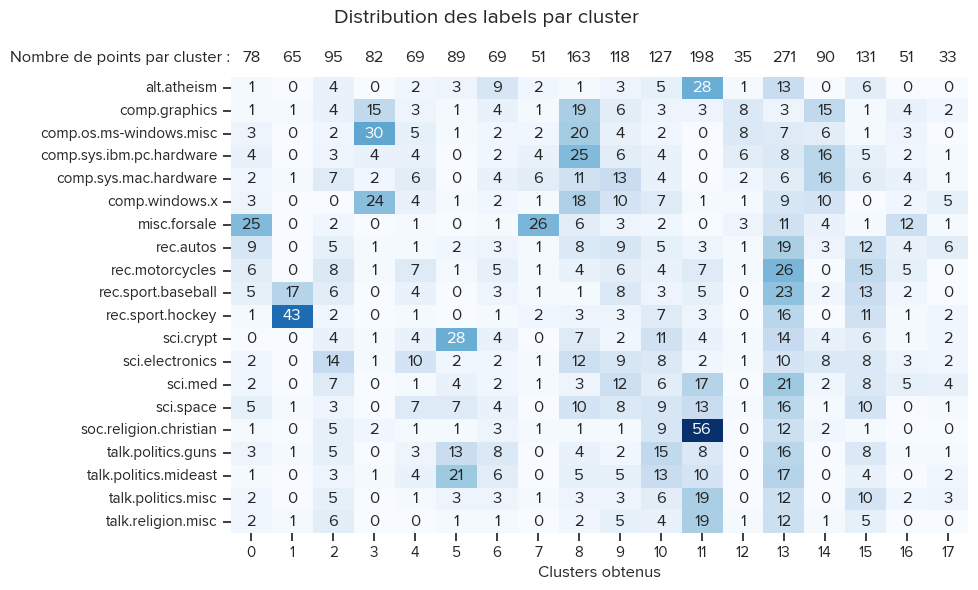

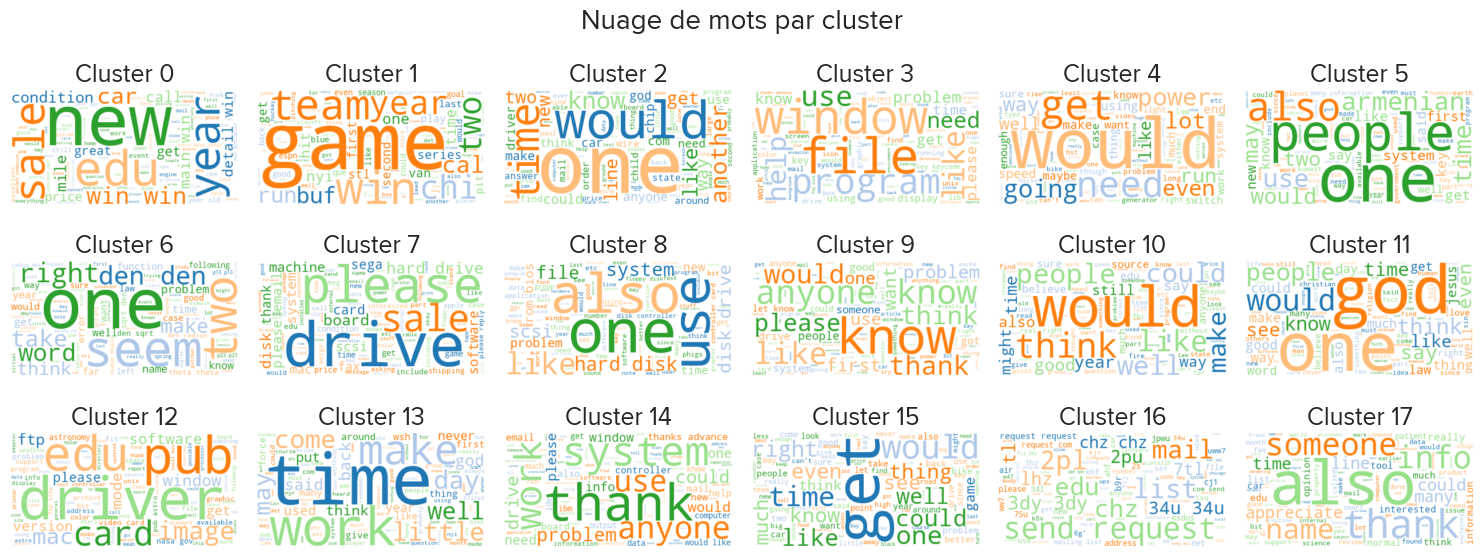

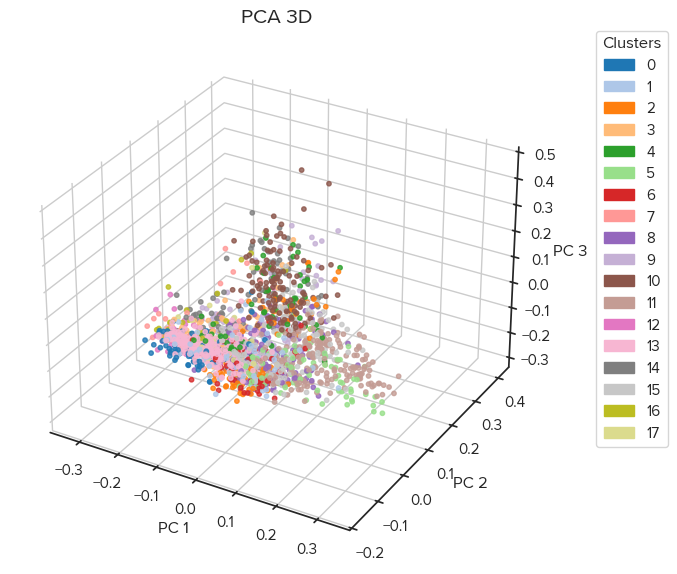

In [ ]:
random.seed(1)
np.random.seed(1)
M = normalize(get_bow_vect(news_no_stopwords, corpus, binary=True))

# PCA dimensionality reduction
model = PCA(n_components=1132, random_state=1)
m_pca = model.fit_transform(M)

# KMeans
centroids, U = clust.kmoyennes(18, m_pca, 0, 300, verbose=False)
U = predict_label(U)

sns.set_theme(style="ticks")
plt.rcParams['font.family'] = 'Proxima Nova'

fig1=distribution_target(news_no_stopwords["target"].values, U, news_no_stopwords["label"].values)
#fig1.savefig("images/no_sw/visual/bow_bin_labels_distr.svg", dpi=150, bbox_inches='tight', format="svg")

fig2=plot_clusters_wordcloud(news_no_stopwords, U, stopwords)
#fig2.savefig("images/no_sw/visual/bow_bin_wordcloud.svg", dpi=150, bbox_inches='tight', format="svg")

fig3=plot_3d_pca(m_pca, U, 1)
#fig3.savefig("images/no_sw/visual/bow_bin_pca.svg", dpi=150, bbox_inches='tight', format="svg")

# Centroids
centers_3d = PCA(n_components=3, random_state=1).fit_transform(centroids)
ax.scatter(centers_3d[:, 0], centers_3d[:, 1], centers_3d[:, 2], marker='x')


### Bag-of-words non binaire

In [ ]:

random.seed(1)
np.random.seed(1)
M = normalize(get_bow_vect(news_no_stopwords, corpus, binary=False))

# PCA dimensionality reduction
model = PCA(n_components=1109, random_state=1)
m_pca = model.fit_transform(M)

# KMeans
centroids, U = clust.kmoyennes(18, m_pca, 0, 300, verbose=False)
U = predict_label(U)

sns.set_theme(style="ticks")
plt.rcParams['font.family'] = 'Proxima Nova'

fig1=distribution_target(news_no_stopwords["target"].values, U, news_no_stopwords["label"].values)
fig1.savefig("images/no_sw/visual/bow_freq_labels_distr.svg", dpi=150, bbox_inches='tight', format="svg")

fig2=plot_clusters_wordcloud(news_no_stopwords, U, stopwords)
fig2.savefig("images/no_sw/visual/bow_freq_wordcloud.svg", dpi=150, bbox_inches='tight', format="svg")

fig3=plot_3d_pca(m_pca, U, 1)
fig3.savefig("images/no_sw/visual/bow_freq_pca.svg", dpi=150, bbox_inches='tight', format="svg")

ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

### Tf-Idf

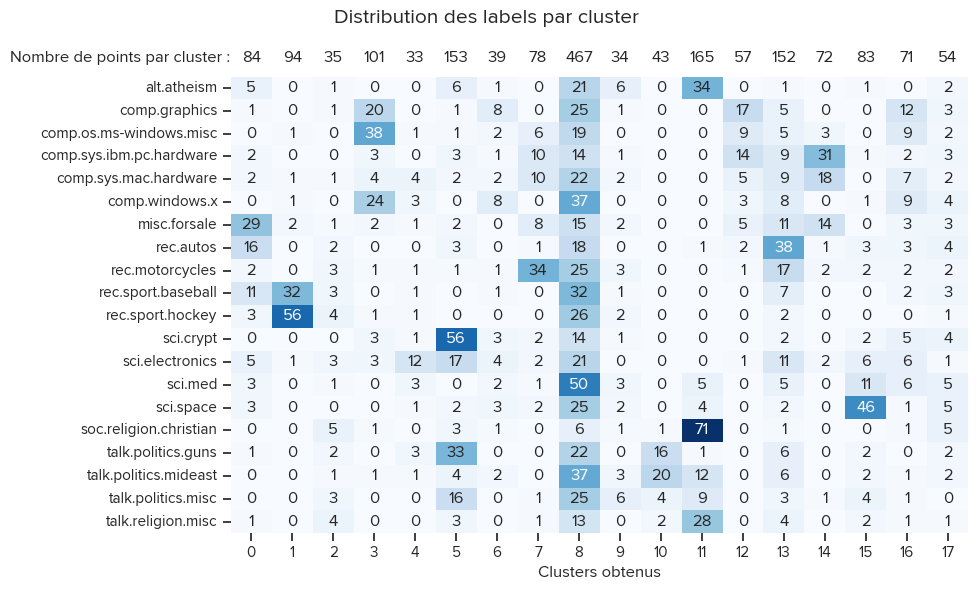

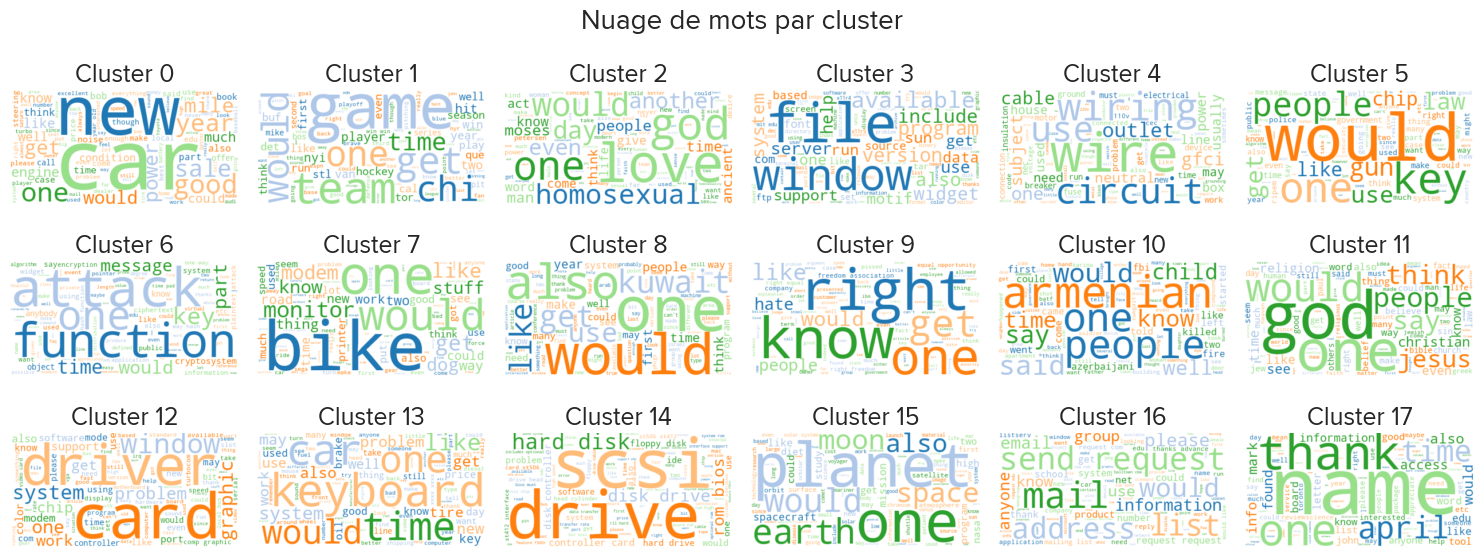

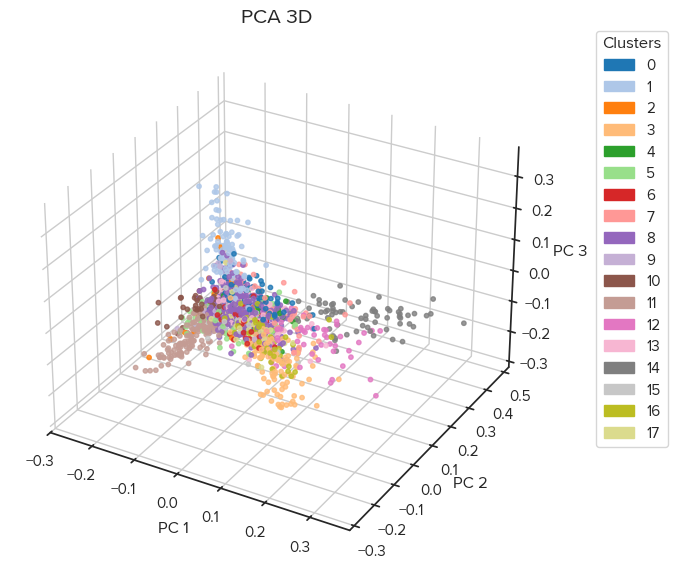

In [97]:
from matplotlib.patches import Patch

random.seed(1)
np.random.seed(1)
M = normalize(get_tfidf_vect(news_no_stopwords, corpus))

# PCA dimensionality reduction
model = PCA(n_components=1249, random_state=1)
m_pca = model.fit_transform(M)

# KMeans
centroids, U = clust.kmoyennes(18, m_pca, 0, 300, verbose=False)
U = predict_label(U)

sns.set_theme(style="ticks")
plt.rcParams['font.family'] = 'Proxima Nova'

fig1=distribution_target(news_no_stopwords["target"].values, U, news_no_stopwords["label"].values)
fig1.savefig("images/no_sw/visual/tfidf_labels_distr.svg", dpi=150, bbox_inches='tight', format="svg")

fig2=plot_clusters_wordcloud(news_no_stopwords, U, stopwords)
fig2.savefig("images/no_sw/visual/tfidf_wordcloud.svg", dpi=150, bbox_inches='tight',format="svg")

fig3=plot_3d_pca(m_pca, U, 1)
fig3.savefig("images/no_sw/visual/tfidf_pca.svg", dpi=150, bbox_inches='tight',format="svg")